#1. Tải và tiền xử lý dữ liệu ban đầu

In [1]:
import json
import pandas as pd
import torch # Bạn sẽ cần thư viện này cho phần sau của code
from PIL import Image # Bạn sẽ cần thư viện này cho phần sau của code
import requests # Bạn sẽ cần thư viện này cho phần sau của code
from io import BytesIO # Bạn sẽ cần thư viện này cho phần sau của code


# Mở tệp JSON và tải dữ liệu
with open('all_labeled.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Khởi tạo một DataFrame rỗng với các cột mong muốn
df = pd.DataFrame(columns=[
    'id', 'user_name', 'rating', 'comment', 'images', 'created_at',
    'thank_count', 'product_id', 'product_name', 'product_url',
    'product_image', 'Image_helpfulness', 'Comment_helpfulness', 'All_helpfulness' # Thêm các cột cho helpfulness khác nếu cần
])

# Danh sách để lưu trữ các hàng mới
new_rows = []

# Lặp qua từng mục (review) trong dữ liệu
for item in data:
    # Lấy thông tin cơ bản từ 'data'
    item_data = item.get('data', {})
    review_id = item.get('id')
    user_name = item_data.get('user_name')
    rating = item_data.get('rating')
    comment = item_data.get('comment')
    images = item_data.get('images')
    created_at = item_data.get('created_at')
    thank_count = item_data.get('thank_count')
    product_id = item_data.get('product_id')
    product_name = item_data.get('product_name')
    product_url = item_data.get('product_url')
    product_image = item_data.get('product_image')

    # Khởi tạo các giá trị helpfulness mặc định là None cho mỗi bản ghi
    # Nếu không tìm thấy, nó sẽ giữ giá trị None, hoặc bạn có thể đặt là 0 tùy ý
    image_helpfulness_value = None
    comment_helpfulness_value = None
    all_helpfulness_value = None

    # Lấy phần chú thích (annotations)
    annotations = item.get('annotations')
    if annotations and len(annotations) > 0:
        results = annotations[0].get('result', [])
        for annotation_item in results:
            from_name = annotation_item.get('from_name')
            value_choices = annotation_item.get('value', {}).get('choices')

            if value_choices and len(value_choices) > 0:
                extracted_value = value_choices[0]

                if from_name == 'Image_helpfulness':
                    image_helpfulness_value = extracted_value
                elif from_name == 'Comment_helpfulness':
                    comment_helpfulness_value = extracted_value
                elif from_name == 'All_helpfulness':
                    all_helpfulness_value = extracted_value

    # Tạo một hàng mới với tất cả các thông tin đã trích xuất
    new_row = {
        'id': review_id,
        'user_name': user_name,
        'rating': rating,
        'comment': comment,
        'images': images,
        'created_at': created_at,
        'thank_count': thank_count,
        'product_id': product_id,
        'product_name': product_name,
        'product_url': product_url,
        'product_image': product_image,
        'Image_helpfulness': image_helpfulness_value,
        'Comment_helpfulness': comment_helpfulness_value,
        'All_helpfulness': all_helpfulness_value
    }
    new_rows.append(new_row)

# Thêm tất cả các hàng mới vào DataFrame một lần
df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

print("Data extraction and DataFrame creation complete. Checking Image_helpfulness values:")
# Hiển thị vài hàng đầu của DataFrame để kiểm tra
print(df.head())

# Bạn cũng có thể kiểm tra một cột cụ thể
print("\nGiá trị của cột 'Image_helpfulness':")
print(df['Image_helpfulness'].value_counts(dropna=False))

# Example of how you would continue with your existing code after this:
image_paths = []
text_data = []
ratings = []

for index, row in df.iterrows():
    ratings.append(row['rating'])
    text_data.append(row['comment'])
    
    # Lấy URL của hình ảnh đầu tiên nếu có
    if row['images'] and isinstance(row['images'], list) and len(row['images']) > 0:
        image_paths.append(row['images'][0])
    else:
        image_paths.append(None) # Trường hợp không có hình ảnh
    
    text_data.append(comment)
    ratings.append(rating)

print("Data extraction complete")


Data extraction and DataFrame creation complete. Checking Image_helpfulness values:
    id         user_name rating  \
0  211         Mint Mint      5   
1  212  Nguyễn Bích Hạnh      5   
2  213           Lan Anh      5   
3  214          Tâm Châu      1   
4  215           Bé Tuấn      2   

                                             comment  \
0                          giao hàng nhanh và hsd xa   
1  Truyện rất hay mình bàng hoàng nhận ra tác giả...   
2  Sản phẩm chất lượng tốt tiện lợi giá cả hợp lý...   
3   Giao hàng nhanh nhưng máy kêu rất to như máy cày   
4  giao hàng nhanh nhưng mà sách lại bị ố vàng ng...   

                                              images     created_at  \
0  [https://salt.tikicdn.com/ts/review/8f/d2/cf/0...  1640476800000   
1                                                 []  1625097600000   
2                                                 []  1661126400000   
3                                                 []  1649894400000   
4  [https://s

#2. Chia data train/test

In [2]:
from sklearn.model_selection import train_test_split

# --- Bước 2: Chuẩn bị dữ liệu để chia train/test ---

# Lấy các đặc trưng (features) và nhãn (labels) từ DataFrame 'df'
# BẮT ĐẦU SỬA ĐỔI TẠI ĐÂY
# Lọc bỏ các hàng có Image_helpfulness là None hoặc '0'
df_filtered = df[df['Image_helpfulness'].notna()] # Loại bỏ các hàng có Image_helpfulness là None
df_filtered = df_filtered[df_filtered['Image_helpfulness'] != '0'] # Loại bỏ các hàng có Image_helpfulness là '0'

# Chuyển đổi nhãn Image_helpfulness sang kiểu số nguyên
# Đảm bảo rằng tất cả các giá trị còn lại đều có thể chuyển thành int
try:
    y_labels = df_filtered['Image_helpfulness'].astype(int).tolist()
except ValueError as e:
    print(f"Lỗi: Không thể chuyển đổi 'Image_helpfulness' sang số nguyên sau khi lọc. Kiểm tra dữ liệu của bạn. Lỗi: {e}")
    # Nếu vẫn còn lỗi, bạn có thể in df_filtered['Image_helpfulness'].value_counts() để xem giá trị nào không hợp lệ.


X_comments = df_filtered['comment'].tolist()
X_image_urls = [
    row['images'][0] if row['images'] and isinstance(row['images'], list) and len(row['images']) > 0 else None
    for index, row in df_filtered.iterrows() # Lặp trên df_filtered
]
# KẾT THÚC SỬA ĐỔI

# Gộp comment và image_url lại thành một danh sách các cặp để chia đồng bộ
X_combined = list(zip(X_comments, X_image_urls))

# Đảm bảo stratify_param chỉ được dùng nếu có đủ các lớp
stratify_param = y_labels if len(set(y_labels)) > 1 and min(pd.Series(y_labels).value_counts()) >= 2 else None


X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X_combined, y_labels, test_size=0.2, random_state=42, stratify=stratify_param
)

# Tách lại comment và image_url cho tập train và test
X_train_comments, X_train_image_urls = zip(*X_train_combined)
X_test_comments, X_test_image_urls = zip(*X_test_combined)

# Chuyển đổi lại về list để dễ sử dụng
X_train_comments = list(X_train_comments)
X_train_image_urls = list(X_train_image_urls)
X_test_comments = list(X_test_comments)
X_test_image_urls = list(X_test_image_urls)


print(f"\nChia tập train/test hoàn tất:")
print(f"Số lượng mẫu training: {len(X_train_comments)}")
print(f"Số lượng mẫu testing: {len(X_test_comments)}")
print(f"y_train (10 phần tử đầu): {y_train[:10]}")
print(f"y_test (10 phần tử đầu): {y_test[:10]}")


Chia tập train/test hoàn tất:
Số lượng mẫu training: 1808
Số lượng mẫu testing: 453
y_train (10 phần tử đầu): [1, 3, 1, 3, 5, 5, 2, 2, 5, 1]
y_test (10 phần tử đầu): [1, 3, 2, 4, 1, 1, 1, 3, 1, 1]


#3. Tiền xử lý dữ liệu hình ảnh

In [3]:
from transformers import BertTokenizer, BertModel
import torchvision.transforms as transforms

# Preprocessing for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Preprocessing for ResNet50
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device) # Đảm bảo BERT model cũng được đưa lên device

# Hàm hỗ trợ xử lý hình ảnh (để tránh lặp code)
def process_images(image_urls_list, transform_func, device):
    image_tensors = []
    for img_url in image_urls_list:
        if img_url:
            try:
                response = requests.get(img_url, timeout=10) # Thêm timeout để tránh request bị treo
                img = Image.open(BytesIO(response.content)).convert("RGB")
                img_tensor = transform_func(img).unsqueeze(0).to(device)
                image_tensors.append(img_tensor)
            except Exception as e:
                print(f"Lỗi khi tải hoặc xử lý ảnh từ URL: {img_url}. Lỗi: {e}")
                image_tensors.append(torch.zeros(1, 3, 224, 224).to(device)) # Thêm tensor rỗng nếu lỗi
        else:
            image_tensors.append(torch.zeros(1, 3, 224, 224).to(device)) # Placeholder cho ảnh bị thiếu
    if not image_tensors: # Trường hợp danh sách rỗng sau khi xử lý
        return torch.empty(0, 3, 224, 224).to(device)
    return torch.cat(image_tensors, dim=0)


# Convert text data to BERT inputs for train and test sets
text_inputs_train = tokenizer(X_train_comments, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
text_inputs_test = tokenizer(X_test_comments, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)

# Process the images for train and test sets
image_tensors_train = process_images(X_train_image_urls, resnet_transform, device)
image_tensors_test = process_images(X_test_image_urls, resnet_transform, device)

print("Image and text preprocessing complete for train and test sets.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\pc\AppData\Roaming\Python\Python313\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pc\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Image and text preprocessing complete for train and test sets.


#4. Định nghĩa mô hình Resnet50 cho Hồi quy

In [4]:
import torch.nn as nn
import torchvision.models as models

# Load ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# Modify the last fully connected layer FOR REGRESSION (output 1 giá trị liên tục)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 1)

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)
print("ResNet50 model loaded and modified for regression.")

# Định nghĩa hàm mất mát cho bài toán hồi quy (Mean Squared Error)
criterion = nn.MSELoss()
print("Loss function set to MSELoss for regression.")

C:\Users\pc\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\pc\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50 model loaded and modified for regression.
Loss function set to MSELoss for regression.


#5.Huấn luyện mô hình

In [7]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau # Thêm scheduler

# Đảm bảo y_train và y_test là float32 cho bài toán hồi quy
# (Không cần 0-indexed như phân loại)

# Định nghĩa batch size
batch_size = 32

# Định nghĩa số lượng epochs
num_epochs = 30 # Thử tăng số epochs để mô hình có cơ hội học tốt hơn

# Tạo dataset từ tensor (chỉ dùng image_tensors_train)
train_dataset = TensorDataset(image_tensors_train, torch.tensor(y_train, dtype=torch.float32))

# Tạo DataLoader với batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Tạo optimizer (sử dụng Adam optimizer)
# Áp dụng weight_decay (L2 regularization) để giảm overfit
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001, weight_decay=1e-5) # Giảm LR và thêm weight_decay

# Khởi tạo Learning Rate Scheduler
# Giảm LR khi validation loss không cải thiện sau 'patience' epoch
# mode='min' vì chúng ta muốn giảm loss
# factor=0.1: LR mới = LR cũ * 0.1
# patience=5: Chờ 5 epoch không cải thiện rồi mới giảm LR
# --- BỎ THAM SỐ 'verbose=True' TẠI ĐÂY ---
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


# Huấn luyện mô hình với DataLoader
print("\nBắt đầu huấn luyện mô hình ResNet50 (hồi quy)...")
for epoch in range(num_epochs):
    resnet50.train()
    epoch_loss = 0

    for batch_images, batch_labels in train_loader:
        # Đưa dữ liệu lên device
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

        # Tiến hành forward pass
        optimizer.zero_grad() # Reset gradients
        outputs = resnet50(batch_images) # Dự đoán từ mô hình (giờ là 1 giá trị liên tục)
        loss = criterion(outputs.squeeze(), batch_labels) # Tính loss (vẫn squeeze cho hồi quy)

        # Backpropagation
        loss.backward() # Tính gradient
        optimizer.step() # Cập nhật weights

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    # In kết quả mỗi epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")

    # Cập nhật scheduler
    scheduler.step(avg_epoch_loss)

print("ResNet50 model fine-tuned for regression.")


Bắt đầu huấn luyện mô hình ResNet50 (hồi quy)...
Epoch 1/30, Loss: 1.2210
Epoch 2/30, Loss: 0.3917
Epoch 3/30, Loss: 0.2171
Epoch 4/30, Loss: 0.1489
Epoch 5/30, Loss: 0.1280
Epoch 6/30, Loss: 0.1018
Epoch 7/30, Loss: 0.1055
Epoch 8/30, Loss: 0.0868
Epoch 9/30, Loss: 0.0975
Epoch 10/30, Loss: 0.0885
Epoch 11/30, Loss: 0.0725
Epoch 12/30, Loss: 0.0684
Epoch 13/30, Loss: 0.0506
Epoch 14/30, Loss: 0.0467
Epoch 15/30, Loss: 0.0482
Epoch 16/30, Loss: 0.0425
Epoch 17/30, Loss: 0.0448
Epoch 18/30, Loss: 0.0369
Epoch 19/30, Loss: 0.0392
Epoch 20/30, Loss: 0.0455
Epoch 21/30, Loss: 0.0353
Epoch 22/30, Loss: 0.0304
Epoch 23/30, Loss: 0.0299
Epoch 24/30, Loss: 0.0295
Epoch 25/30, Loss: 0.0393
Epoch 26/30, Loss: 0.0389
Epoch 27/30, Loss: 0.0363
Epoch 28/30, Loss: 0.0342
Epoch 29/30, Loss: 0.0361
Epoch 30/30, Loss: 0.0296
ResNet50 model fine-tuned for regression.


#6.Đánh giá mô hình

In [8]:
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score
import numpy as np
from torch.utils.data import TensorDataset, DataLoader # Để tạo DataLoader cho tập test

# Tạo TensorDataset và DataLoader cho tập test (chỉ dùng image_tensors_test)
test_dataset = TensorDataset(image_tensors_test, torch.tensor(y_test, dtype=torch.float32)) # y_test vẫn là float32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Không shuffle tập test

# Evaluate the model
resnet50.eval() # Chuyển mô hình sang chế độ đánh giá

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        outputs = resnet50(batch_images) # Dự đoán liên tục
        all_predictions.extend(outputs.squeeze().cpu().numpy())
        all_true_labels.extend(batch_labels.cpu().numpy())

predictions = np.array(all_predictions)
y_true = np.array(all_true_labels)


# --- Tính toán các chỉ số cho hồi quy ---
r2 = r2_score(y_true, predictions)
mse = mean_squared_error(y_true, predictions)


# --- Tính toán Accuracy và F1 Score từ kết quả hồi quy (bằng cách làm tròn) ---
# Bước 1: Làm tròn các dự đoán về số nguyên gần nhất
predicted_classes = np.round(predictions)

# Bước 2: Đảm bảo các dự đoán nằm trong phạm vi hợp lệ của nhãn (1 đến 5)
predicted_classes = np.clip(predicted_classes, 1, 5)

# Đảm bảo y_true là số nguyên để so sánh cho Accuracy/F1
y_true_int = y_true.astype(int)
predicted_classes_int = predicted_classes.astype(int)


# Tính toán Accuracy
accuracy = accuracy_score(y_true_int, predicted_classes_int)

# Tính toán F1 Score (weighted)
f1 = f1_score(y_true_int, predicted_classes_int, average='weighted', zero_division=0) # zero_division=0 để tránh warning nếu có lớp nào đó không được dự đoán


# In kết quả
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"Accuracy (derived from regression): {accuracy:.4f}")
print(f"F1 Score (weighted, derived from regression): {f1:.4f}")

R² Score: 0.7253
MSE: 0.5880
Accuracy (derived from regression): 0.6336
F1 Score (weighted, derived from regression): 0.6324


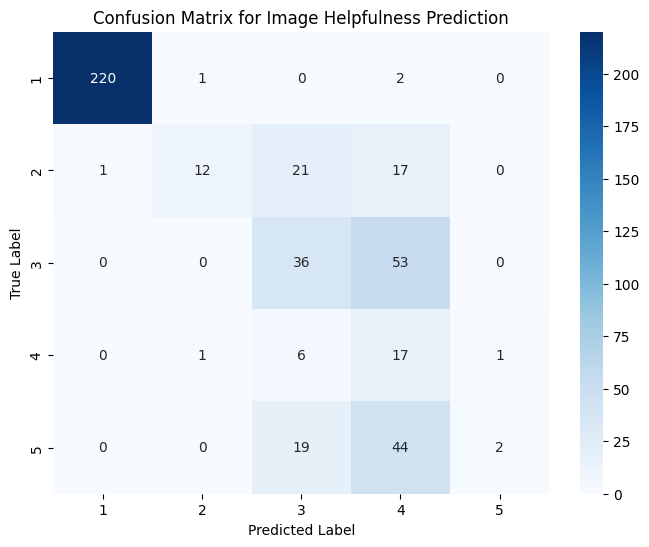


Detailed Classification Report (from rounded regression results):
              precision    recall  f1-score   support

           1       1.00      0.99      0.99       223
           2       0.86      0.24      0.37        51
           3       0.44      0.40      0.42        89
           4       0.13      0.68      0.22        25
           5       0.67      0.03      0.06        65

    accuracy                           0.63       453
   macro avg       0.62      0.47      0.41       453
weighted avg       0.78      0.63      0.63       453



In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Cần các nhãn thực tế (y_true_int) và các lớp dự đoán (predicted_classes_int)
cm = confusion_matrix(y_true_int, predicted_classes_int)

# Tên các lớp (từ 1 đến 5)
labels = [str(i) for i in range(1, 6)]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Image Helpfulness Prediction')
plt.show()
from sklearn.metrics import classification_report
print("\nDetailed Classification Report (from rounded regression results):")
print(classification_report(y_true_int, predicted_classes_int, target_names=labels, zero_division=0))